In [22]:
!python -V

In [23]:
import pandas as pd

In [24]:
import pickle

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Number of records

In [29]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')

df.shape

(1154112, 7)

In [30]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


## Averation duration in Jan 2021

In [32]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.mean()


19.167224093791006

## Number of dropped records

In [34]:
df_reduct = df[(df.duration >= 1) & (df.duration <= 60)]
reducted = df.shape[0] - df_reduct.shape[0]
reducted

44286

## Fraction of missing values

In [40]:
df_filled = df_reduct.copy()
df_filled['PUlocationID'].fillna('-1', inplace=True)
df_filled['DOlocationID'].fillna('-1', inplace=True)
missing = df_filled[df_filled['PUlocationID']=='-1'].shape[0] / df_filled.shape[0]
missing

0.8352732770722617

## Number of columns of the one-hot encoded matrix

In [72]:
categorical = ['PUlocationID', 'DOlocationID']

df_filled[categorical] = df_filled[categorical].astype(str)

train_dicts = df_filled[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

X_train.shape[1]

525

## Train RMSE

In [73]:
target = 'duration'
y_train = df_filled[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.52851942801014

/Users/cedricsoares/miniforge3/envs/mlops_zoomcamp/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cedricsoares/miniforge3/envs/mlops_zoomcamp/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


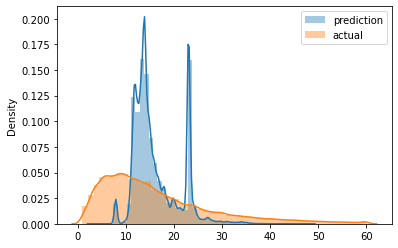

In [65]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

## Val RMSE

In [66]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [67]:
df_train = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [68]:
len(df_train), len(df_val)

(1109826, 990113)

In [69]:
categorical =  ['PUlocationID', 'DOlocationID']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [70]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [71]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.014286431706232